<!-- LAB U-Net Model -->
<div class="alert" style="background: linear-gradient(to right, rgb(100,100,100), rgb(200,200,200)); color:white;">

# **U-NET LAB Colorization Model**
***
This notebook implements a U-Net model for image colorization using the LAB color space. The model takes grayscale images (L channel) as input and predicts the a* and b* color channels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Src')
from unet_model import build_unet, get_callbacks
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

In [2]:
# GPU Check & Mixed Precision Setup for TensorFlow
import tensorflow as tf
from tensorflow.python.client import device_lib

print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

print("Device List:")
for device in device_lib.list_local_devices():
    print(f" - {device.name} ({device.device_type})")

# Enable mixed precision for performance if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled (float16).")
    except Exception as e:
        print(f"Could not enable mixed precision: {e}")
else:
    print("No GPU detected. Running on CPU.")

TensorFlow version: 2.10.0
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device List:
 - /device:CPU:0 (CPU)
 - /device:GPU:0 (GPU)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6
Mixed precision enabled (float16).


In [3]:
# Load and preprocess data
x_train = np.load("../Data/prepared_data/LAB/comic_input_grayscale_train.npy")
y_train = np.load("../Data/prepared_data/LAB/comic_output_color_train.npy")
x_test  = np.load("../Data/prepared_data/LAB/comic_input_grayscale_test.npy")
y_test  = np.load("../Data/prepared_data/LAB/comic_output_color_test.npy")

# casting to float32 because GPU training is better at float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print("Memory growth setup failed:", e)


Memory growth enabled


In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Build model
input_shape = x_train.shape[1:]  # (256, 256, 1) for grayscale
model = build_unet(input_shape=(256, 256, 1), output_channels=2, use_scaling=False) # 2 output channels for LAB


# Combined loss with correct dtype
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    loss = 0.84 * mse + 0.16 * mae
    return tf.cast(loss, tf.float32)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['mae']
)

# Callbacks
checkpoint_cb = ModelCheckpoint("U-NET_LAB_best_model_v2.keras", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(patience=20, restore_best_weights=True)

In [6]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

print("Model input:", model.input_shape)
print("Model output:", model.output_shape)


x_train: (256, 256, 256, 1)
y_train: (256, 256, 256, 2)
x_test: (64, 256, 256, 1)
y_test: (64, 256, 256, 2)
Model input: (None, 256, 256, 1)
Model output: (None, 256, 256, 2)


In [7]:
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)
print("Model output dtype:", model.output.dtype)


x_train dtype: float32
y_train dtype: float32
Model output dtype: <dtype: 'float16'>


Training loop

In [8]:
import tensorflow as tf
tf.keras.backend.clear_session() # Clear GPU memory before training

# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Save training history to CSV
import pandas as pd
pd.DataFrame(history.history).to_csv("training_log_lab.csv", index=False)

model.save("U-NET_LAB_final_trained_v2.keras")
print("Saved best and final model.")


Epoch 1/300
8/8 [==============================] - 25s 402ms/step - loss: nan - mae: 0.5082 - val_loss: nan - val_mae: 0.0821
Epoch 2/300
8/8 [==============================] - 3s 369ms/step - loss: nan - mae: 0.5085 - val_loss: nan - val_mae: 0.0951
Epoch 3/300
8/8 [==============================] - 3s 368ms/step - loss: nan - mae: 0.5081 - val_loss: nan - val_mae: 0.1124
Epoch 4/300
8/8 [==============================] - 3s 368ms/step - loss: nan - mae: 0.5084 - val_loss: nan - val_mae: 0.1307
Epoch 5/300
8/8 [==============================] - 3s 368ms/step - loss: nan - mae: 0.5084 - val_loss: nan - val_mae: 0.1493
Epoch 6/300
8/8 [==============================] - 3s 369ms/step - loss: nan - mae: 0.5081 - val_loss: nan - val_mae: 0.1679
Epoch 7/300
8/8 [==============================] - 3s 370ms/step - loss: nan - mae: 0.5082 - val_loss: nan - val_mae: 0.1859
Epoch 8/300
8/8 [==============================] - 3s 370ms/step - loss: nan - mae: 0.5079 - val_loss: nan - val_mae: 0.2030

<Axes: >

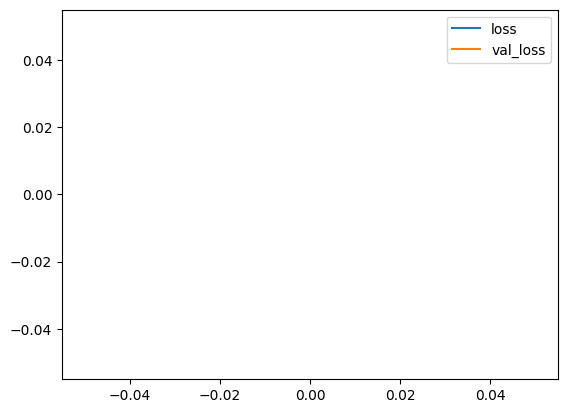

In [9]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [10]:
predictions = model.predict(x_test[:100])
print("Pred min/max:", predictions.min(), predictions.max())
print("GT min/max:", y_test[:100].min(), y_test[:100].max())

2/2 [==============================] - 0s 73ms/step
Pred min/max: -0.07306 0.03256
GT min/max: -0.5058824 0.73333335


In [11]:
# Convert LAB channels to RGB image before plotting
def lab_to_rgb_img(ab_channels, l_channel): 
    L = (l_channel.squeeze() * 255).astype(np.uint8)
    A = ((ab_channels[..., 0] + 1.0) * 128).astype(np.uint8)
    B = ((ab_channels[..., 1] + 1.0) * 128).astype(np.uint8)

    lab_img = np.stack([L, A, B], axis=-1)
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
    return rgb_img


In [12]:
# Visualize some results
def plot_results(model, x, y, num_samples=10):
    predictions = model.predict(x[:num_samples])

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    titles = ['Grayscale Input', 'Predicted Color', 'Ground Truth']

    for i in range(num_samples):
        axes[i, 0].imshow(x[i].squeeze(), cmap='gray')

        ab_pred = ((predictions[i] * 1.0).clip(-1, 1))  # AB is already in [-1, 1]
        ab_true = ((y[i] * 1.0).clip(-1, 1))

        pred_rgb = lab_to_rgb_img(ab_pred, x[i])
        true_rgb = lab_to_rgb_img(ab_true, x[i])

        axes[i, 1].imshow(pred_rgb)
        axes[i, 2].imshow(true_rgb)

        for j in range(3):
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(titles[j])

    plt.tight_layout()
    plt.show()


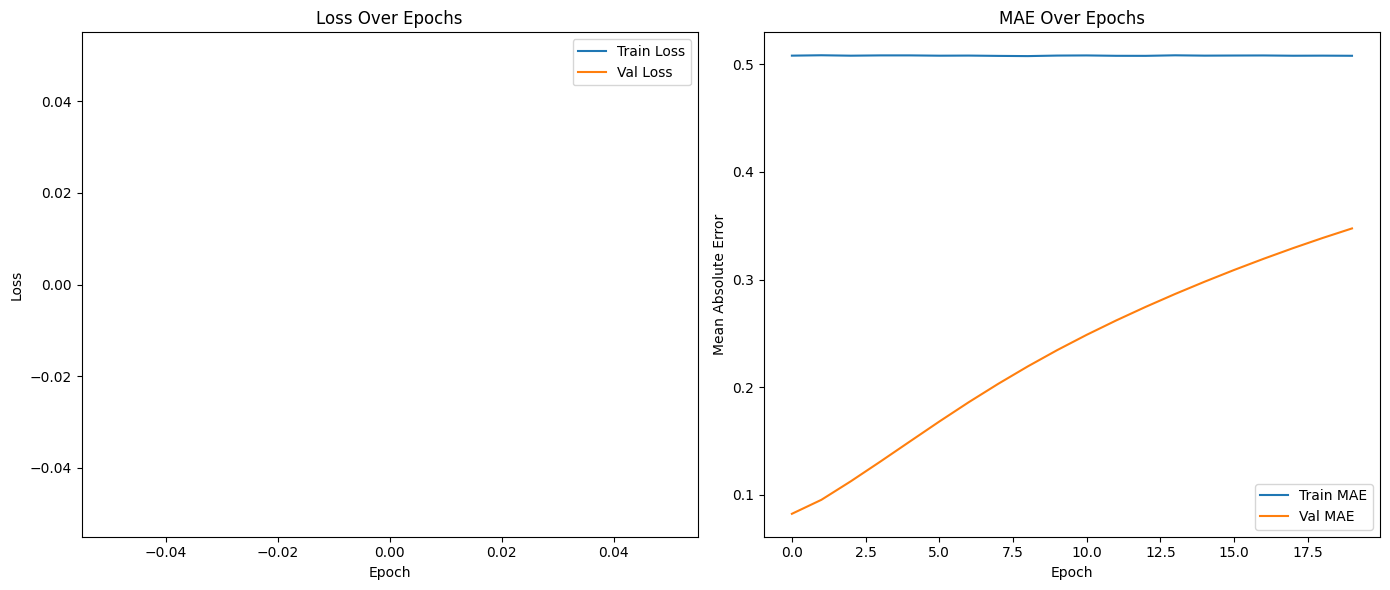

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload training log
log_path = "training_log_lab.csv"
df = pd.read_csv(log_path)

# Plot loss and MAE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df["loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["mae"], label="Train MAE")
plt.plot(df["val_mae"], label="Val MAE")
plt.title("MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()